In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import os
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_CNO_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Fe_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_He_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_MgAlSi_addweight_rho_2.5e13_5.0e17_V3.root
# /home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root
r_cut_low=320
r_cut_high=420
theta_cut_low=10/180*np.pi
theta_cut_high=30/180*np.pi

def open_file(file_name):
    with uproot.open(file_name) as file:
        tree = file["Rec"]
        branches_to_read = ["E", "theta","phi","corex","corey","rec_x","rec_y","rec_theta","rec_phi","rec_Eage","Redge",
                            "NpE3","NuM1","NuM2","NuM3","NuM4","NuM5","NuW2","weightGaisser"]
        df = tree.arrays(branches_to_read, library="pd")
        all_weights = df['weightGaisser'].sum()
        print(file_name)
        print("     Entries:", tree.num_entries)
        print("     Total weights:", all_weights)
        cuts_indices = (df['rec_Eage'] > 0) & (df['Redge'] > 0) & (df['rec_theta'] > theta_cut_low) & (df['rec_theta'] < theta_cut_high)  & (df["NuW2"]>0) & (df["NpE3"]>80)
        df_cut = df[cuts_indices].copy() 
        
        df_cut["R_ue"]=np.log10((1e-4+df_cut["NuM1"])/(df_cut["NpE3"]+1))
        print(f"     Entries after cut: {df_cut.shape[0]}")
        del df
        return df_cut

proton_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root")
he_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_He_addweight_rho_2.5e13_5.0e17_V3.root")
cno_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_CNO_addweight_rho_2.5e13_5.0e17_V3.root")
fe_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Fe_addweight_rho_2.5e13_5.0e17_V3.root")
mgalsi_df = open_file("/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_MgAlSi_addweight_rho_2.5e13_5.0e17_V3.root")

# rec E
# /home/zhonghua/data/Dataset_Filted/CosmicRay/energy_correction_xgb_NuW2_8-12.json
from xgboost import XGBRegressor
model = XGBRegressor()
model.load_model("/home/zhonghua/Filt_Event/models/energy_correction_xgb_NuW2_8-12.json")

def energy_correction(df):
    theta=df["rec_theta"].values
    # df["NuW2"]  theta 作为输入
    feature_data = np.column_stack((df["NuW2"].values, theta))
    corrected_energy = model.predict(feature_data)
    df["recE"]=corrected_energy  # log10(TeV)
    return df

proton_df=energy_correction(proton_df)
he_df=energy_correction(he_df)
cno_df=energy_correction(cno_df)
fe_df=energy_correction(fe_df)
mgalsi_df=energy_correction(mgalsi_df)


proton_df.columns



/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Proton_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14217778
     Total weights: 189.58057618423743
     Entries after cut: 5573943
/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_He_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14210418
     Total weights: 202.9194024482034
     Entries after cut: 4575126
/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_CNO_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14218958
     Total weights: 76.53199899625999
     Entries after cut: 3286951
/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_Fe_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14217887
     Total weights: 74.04563549158364
     Entries after cut: 1775344
/home/zhonghua/data/Dataset_Filted/CosmicRay/QF_MgAlSi_addweight_rho_2.5e13_5.0e17_V3.root
     Entries: 14220016
     Total weights: 35.65026967287873
     Entries after cut: 2550528


In [ ]:
proton_df.columns



Index(['E', 'theta', 'phi', 'corex', 'corey', 'rec_x', 'rec_y', 'rec_theta',
       'rec_phi', 'rec_Eage', 'Redge', 'NpE3', 'NuM1', 'NuW2', 'weightGaisser',
       'R_ue', 'recE', 'r'],
      dtype='object')

In [32]:
muon_params_dict={
    "NuM1":[15,200],
    "NuM2":[40,100],
    "NuM3":[40,200],
    "NuM4":[15,400],
    "NuM5":[15,800],
}
r_low=320
r_high=420
theta_low=10 / 180.0 * np.pi
theta_high=30 / 180.0 * np.pi
Eage_low=0.8
Eage_high=1.2
R_ue_high=-5.0
log10TeV_low=1.7969200611114502
log10TeV_high=2.1131057739257812


def selection_pre(df, mc=True):

    # Index(['E', 'theta', 'phi', 'corex', 'corey', 'rec_x', 'rec_y', 'rec_theta',
    #    'rec_phi', 'rec_Eage', 'Redge', 'NpE3', 'NuM1', 'NuW2', 'weightGaisser',
    #    'R_ue', 'recE', 'r'],
    #   dtype='object')
    recE= df["recE"].values
    R_ue = df["R_ue"].values
    Eage = df["rec_Eage"].values
    rec_x = np.asarray(df["rec_x"].values, dtype=np.float64)
    rec_y = np.asarray(df["rec_y"].values, dtype=np.float64)
    r = np.sqrt(rec_x**2 + rec_y**2)
    rec_theta = df["rec_theta"].values
    initial_count = len(recE)
    current_mask = np.ones(initial_count, dtype=bool)
    # ----------------  ----------------------------------
    # 顺序筛选与打印比例
    # --------------------------------------------------
    print(f"--- 原始数据量: {initial_count} ---")
    
    # 1. 筛选 r (r_low < r < r_high)
    r_mask = (r > r_low) & (r < r_high)
    n_last = current_mask.sum()
    current_mask = current_mask & r_mask
    n_after = current_mask.sum()
    print(f"1. Cut r: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 2. 筛选 theta (theta_low < theta < theta_high)
    theta_mask = (rec_theta > theta_low) & (rec_theta < theta_high)
    n_last = current_mask.sum()
    current_mask = current_mask & theta_mask
    n_after = current_mask.sum()
    print(f"2. Cut theta: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 0. 筛选 log10TeV (log10TeV_low < recE < log10TeV_high)
    log10TeV_mask = (recE > log10TeV_low) & (recE < log10TeV_high)
    n_last = current_mask.sum()
    current_mask = current_mask & log10TeV_mask
    n_after = current_mask.sum()
    print(f"0. Cut log10TeV: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    # 2. 筛选 Eage (Eage_low < Eage < Eage_high)
    Eage_mask = (Eage > Eage_low) & (Eage < Eage_high)
    n_last = current_mask.sum()
    current_mask = current_mask & Eage_mask
    n_after = current_mask.sum()
    print(f"3. Cut Eage: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    if not mc:
        # 4. 筛选 R_ue (R_ue < R_ue_high)
        R_ue_mask = (R_ue < R_ue_high)
        n_last = current_mask.sum()
        current_mask = current_mask & R_ue_mask
        n_after = current_mask.sum()
        print(f"5. Cut R_ue: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # --------------------------------------------------
    # 数据保存 (保持与原函数一致)
    # --------------------------------------------------
    
    # 打印最终统计信息
    final_count = current_mask.sum()
    print(f"\n--- 筛选结果 ---")
    print(f"原始数据量: {initial_count}")
    print(f"筛选后数据量: {final_count}")
    print(f"总通过比例: {final_count/initial_count:.2%}")
    print(f"{'-'*50}")

    return df[current_mask]

proton_df_cut=selection_pre(proton_df, mc=True)
he_df_cut=selection_pre(he_df, mc=True)
cno_df_cut=selection_pre(cno_df, mc=True)
fe_df_cut=selection_pre(fe_df, mc=True)
mgalsi_df_cut=selection_pre(mgalsi_df, mc=True)
print(proton_df_cut["weightGaisser"].sum())
print(he_df_cut["weightGaisser"].sum())
print(cno_df_cut["weightGaisser"].sum())
print(fe_df_cut["weightGaisser"].sum())
print(mgalsi_df_cut["weightGaisser"].sum())

print(f"proton ratio: {proton_df_cut['weightGaisser'].sum() /(proton_df_cut['weightGaisser'].sum() + he_df_cut['weightGaisser'].sum() + cno_df_cut['weightGaisser'].sum() + fe_df_cut['weightGaisser'].sum() + mgalsi_df_cut['weightGaisser'].sum()):.5f}")


--- 原始数据量: 5573943 ---
1. Cut r: 2198738 / 5573943 (Left Ratio: 39.45%)
2. Cut theta: 2198738 / 2198738 (Left Ratio: 100.00%)
0. Cut log10TeV: 187318 / 2198738 (Left Ratio: 8.52%)
3. Cut Eage: 58670 / 187318 (Left Ratio: 31.32%)

--- 筛选结果 ---
原始数据量: 5573943
筛选后数据量: 58670
总通过比例: 1.05%
--------------------------------------------------
--- 原始数据量: 4575126 ---
1. Cut r: 1811635 / 4575126 (Left Ratio: 39.60%)
2. Cut theta: 1811635 / 1811635 (Left Ratio: 100.00%)
0. Cut log10TeV: 133880 / 1811635 (Left Ratio: 7.39%)
3. Cut Eage: 11000 / 133880 (Left Ratio: 8.22%)

--- 筛选结果 ---
原始数据量: 4575126
筛选后数据量: 11000
总通过比例: 0.24%
--------------------------------------------------
--- 原始数据量: 3286951 ---
1. Cut r: 1313062 / 3286951 (Left Ratio: 39.95%)
2. Cut theta: 1313062 / 1313062 (Left Ratio: 100.00%)
0. Cut log10TeV: 116277 / 1313062 (Left Ratio: 8.86%)
3. Cut Eage: 726 / 116277 (Left Ratio: 0.62%)

--- 筛选结果 ---
原始数据量: 3286951
筛选后数据量: 726
总通过比例: 0.02%
-------------------------------------------------

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
muon_params_dict={
    "NuM1":[15,200],
    "NuM2":[40,100],
    "NuM3":[40,200],
    "NuM4":[15,400],
    "NuM5":[15,800],
}
r_low=320
r_high=420
theta_low=10 / 180.0 * np.pi
theta_high=30 / 180.0 * np.pi
Eage_low=0.8
Eage_high=1.2
R_ue_high=-5.0
log10TeV_low=1.7969200611114502
log10TeV_high=2.1131057739257812

def selection_pre(df, mc=True):

    # Index(['E', 'theta', 'phi', 'corex', 'corey', 'rec_x', 'rec_y', 'rec_theta',
    #    'rec_phi', 'rec_Eage', 'Redge', 'NpE3', 'NuM1', 'NuW2', 'weightGaisser',
    #    'R_ue', 'recE', 'r'],
    #   dtype='object')
    recE= df["recE"].values
    R_ue = df["R_ue"].values
    if mc:
        Eage = df["Eage"].values
        rec_x = np.asarray(df["rec_x"].values, dtype=np.float64)
        rec_y = np.asarray(df["rec_y"].values, dtype=np.float64)
        r = np.sqrt(rec_x**2 + rec_y**2)
        rec_theta = df["rec_theta"].values
    else:
        Eage = df["age"].values
        rec_x = np.asarray(df["r_Corex"].values, dtype=np.float64)
        rec_y = np.asarray(df["r_Corey"].values, dtype=np.float64)
        r = np.sqrt(rec_x**2 + rec_y**2)
        rec_theta = df["r_Theta"].values
    initial_count = len(recE)
    current_mask = np.ones(initial_count, dtype=bool)
    # ----------------  ----------------------------------
    # 顺序筛选与打印比例
    # --------------------------------------------------
    print(f"--- 原始数据量: {initial_count} ---")
    
    # 1. 筛选 r (r_low < r < r_high)
    r_mask = (r > r_low) & (r < r_high)
    n_last = current_mask.sum()
    current_mask = current_mask & r_mask
    n_after = current_mask.sum()
    print(f"1. Cut r: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 2. 筛选 theta (theta_low < theta < theta_high)
    theta_mask = (rec_theta > theta_low) & (rec_theta < theta_high)
    n_last = current_mask.sum()
    current_mask = current_mask & theta_mask
    n_after = current_mask.sum()
    print(f"2. Cut theta: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 0. 筛选 log10TeV (log10TeV_low < recE < log10TeV_high)
    log10TeV_mask = (recE > log10TeV_low) & (recE < log10TeV_high)
    n_last = current_mask.sum()
    current_mask = current_mask & log10TeV_mask
    n_after = current_mask.sum()
    print(f"0. Cut log10TeV: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    # 2. 筛选 Eage (Eage_low < Eage < Eage_high)
    Eage_mask = (Eage > Eage_low) & (Eage < Eage_high)
    n_last = current_mask.sum()
    current_mask = current_mask & Eage_mask
    n_after = current_mask.sum()
    print(f"3. Cut Eage: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # if not mc:
    #     # 4. 筛选 R_ue (R_ue < R_ue_high)
    #     R_ue_mask = (R_ue < R_ue_high)
    #     n_last = current_mask.sum()
    #     current_mask = current_mask & R_ue_mask
    #     n_after = current_mask.sum()
    #     print(f"5. Cut R_ue: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # --------------------------------------------------
    # 数据保存 (保持与原函数一致)
    # --------------------------------------------------
    
    # 打印最终统计信息
    final_count = current_mask.sum()
    print(f"\n--- 筛选结果 ---")
    print(f"原始数据量: {initial_count}")
    print(f"筛选后数据量: {final_count}")
    print(f"总通过比例: {final_count/initial_count:.2%}")
    print(f"{'-'*50}")

    return df[current_mask]


def load_npz(file):
    data=np.load(file,allow_pickle=True)
    df=pd.DataFrame(np.asarray(data["params"], dtype=np.float32), columns=data["param_names"])
    return df

def load_exp_TNtuple(file_name):
    with uproot.open(file_name) as file:
        tree = file["ntuple"]
        branches_to_read = ["recE","r_Corex","r_Corey","r_Theta","r_Phi","age",
                            "NpE3","NuM1","NuM2","NuM3","NuM4","NuM5","NuW2",]
        df = tree.arrays(branches_to_read, library="pd")
        print(file_name)
        print("     Entries:", tree.num_entries)
        print("     Total weights Hz:", tree.num_entries/(86400*31))
        df["R_ue"]=np.log10((1e-4+df["NuM1"])/(df["NpE3"]+1))
        return df

def give_weights(params_df):
    rootfile = "/home/zhonghua/data/exposure.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE = np.asarray(trueE, dtype=float)
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1 
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        
        return weights_2d[bin_idx_E, bin_idx_Zen] / 10 / (86400)
    trueE = params_df['trueE'].values
    rec_zenith = params_df['theta'].values
    weights = add_weights(trueE, rec_zenith, weights_2d)
    params_df['weight'] = weights
    return params_df

def R_mean_cut(df, r_mean_low=25, r_mean_high=45):
    df_cut=df[(df["R_mean"] > r_mean_low) & (df["R_mean"] < r_mean_high)]
    return df_cut
# Index(['label', 'weight', 'R_ue', 'R_mean', 'Eage', 'recE', 'rec_x', 'rec_y',
#        'rec_theta', 'rec_phi', 'trueE', 'NuW2', 'NpE3', 'NuM1', 'NuM2', 'NuM3',
#        'NuM4', 'NuM5', 'core_x', 'core_y', 'theta'],
#       dtype='object')

EF_file="/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_EF_Proton_4e13_1e15_dataset_muon.npz"
QF_file="/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_QF_Proton_4e13_1e15_dataset_muon.npz"
QG_file="/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset_muon.npz"
exp_file="/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/2022_01_muon.root"

EF_df=load_npz(EF_file)
EF_df=selection_pre(EF_df, mc=True)
EF_df=give_weights(EF_df)
EF_df['weight']*=(0.7898*0.87635)
# EF_df=R_mean_cut(EF_df)

QF_df=load_npz(QF_file)
QF_df=selection_pre(QF_df, mc=True)
QF_df=give_weights(QF_df)
QF_df['weight']*=(0.7898*0.87635)
# QF_df=R_mean_cut(QF_df)

QG_df=load_npz(QG_file)
QG_df=selection_pre(QG_df, mc=True)
QG_df=give_weights(QG_df)
QG_df['weight']*=0.7898
# QG_df=R_mean_cut(QG_df)

exp_df=load_exp_TNtuple(exp_file)
exp_df=selection_pre(exp_df, mc=False)
exp_df['weight']=np.ones(len(exp_df))/31/86400
# exp_df=R_mean_cut(exp_df)

print(f"EF: {EF_df['weight'].sum()}")
print(f"QF: {QF_df['weight'].sum()}")
print(f"QG: {QG_df['weight'].sum()}")
print(f"Exp: {len(exp_df)/31/86400}")


--- 原始数据量: 374986 ---
1. Cut r: 147009 / 374986 (Left Ratio: 39.20%)
2. Cut theta: 82902 / 147009 (Left Ratio: 56.39%)
0. Cut log10TeV: 16004 / 82902 (Left Ratio: 19.30%)
3. Cut Eage: 4721 / 16004 (Left Ratio: 29.50%)

--- 筛选结果 ---
原始数据量: 374986
筛选后数据量: 4721
总通过比例: 1.26%
--------------------------------------------------
--- 原始数据量: 376375 ---
1. Cut r: 147231 / 376375 (Left Ratio: 39.12%)
2. Cut theta: 83228 / 147231 (Left Ratio: 56.53%)
0. Cut log10TeV: 15047 / 83228 (Left Ratio: 18.08%)
3. Cut Eage: 4358 / 15047 (Left Ratio: 28.96%)

--- 筛选结果 ---
原始数据量: 376375
筛选后数据量: 4358
总通过比例: 1.16%
--------------------------------------------------
--- 原始数据量: 163783 ---
1. Cut r: 37001 / 163783 (Left Ratio: 22.59%)
2. Cut theta: 17786 / 37001 (Left Ratio: 48.07%)
0. Cut log10TeV: 17786 / 17786 (Left Ratio: 100.00%)
3. Cut Eage: 5231 / 17786 (Left Ratio: 29.41%)

--- 筛选结果 ---
原始数据量: 163783
筛选后数据量: 5231
总通过比例: 3.19%
--------------------------------------------------
/home/zhonghua/data/Dataset_Filt

In [18]:
len(exp_df[exp_df["R_ue"]<-5])*12


1512

In [ ]:
muon_params_dict={
    "NuM1":[15,200],   # name + label
    "NuM2":[40,100],
    "NuM3":[40,200],
    "NuM4":[15,400],
    "NuM5":[15,800],
}
df_dict={
    "EF":EF_df,
    "QF":QF_df,
    "QG":QG_df,
    "Exp":exp_df,
}

for NuM_name, r_range in muon_params_dict.items():
    for df_name, df in df_dict.items():
        plt.hist(df[NuM_name],bins=30,weights=df['weight'],label=f"{df_name}: Rate={df['weight'].sum():.3f}, size={len(df)}", histtype="step", alpha=0.8, range=[0,150], density=True)
    plt.legend()
    plt.legend()
    plt.xlabel(NuM_name)
    plt.ylabel("Density")
    plt.yscale("log")
    plt.title(f"{NuM_name}: radius range {r_range} m")
    plt.show()
    plt.close()
        



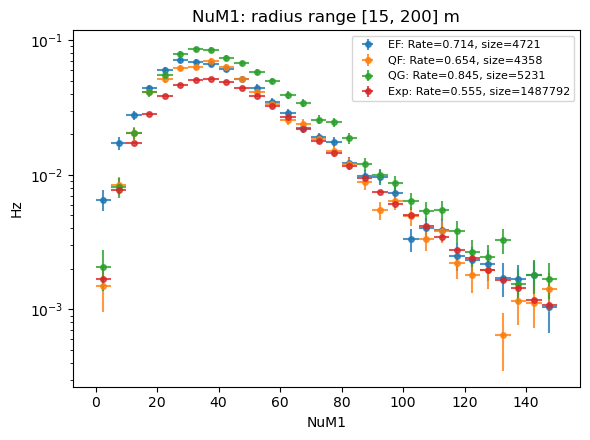

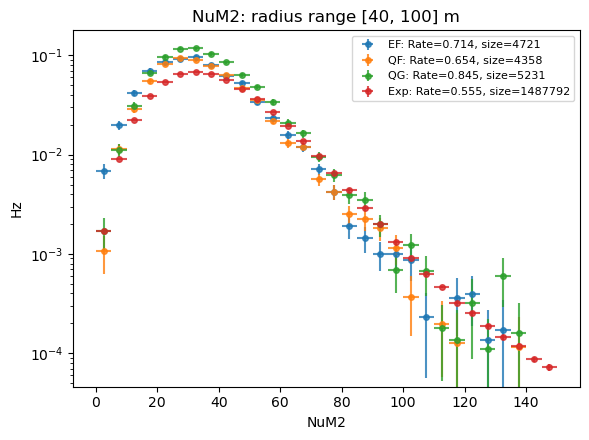

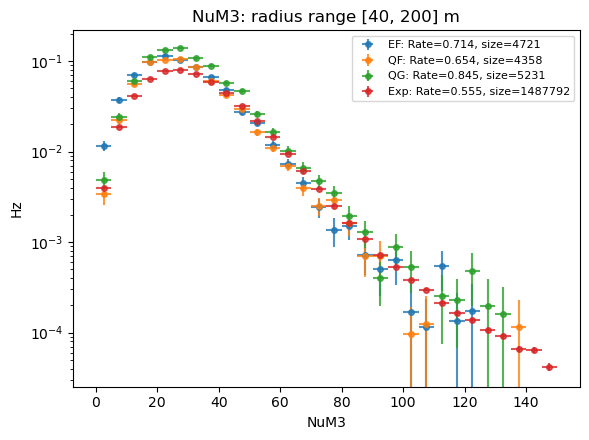

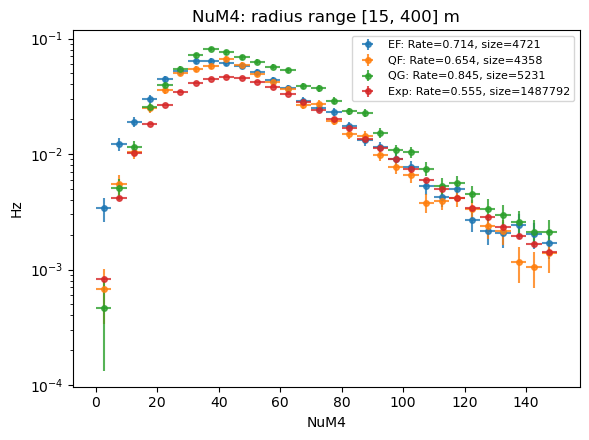

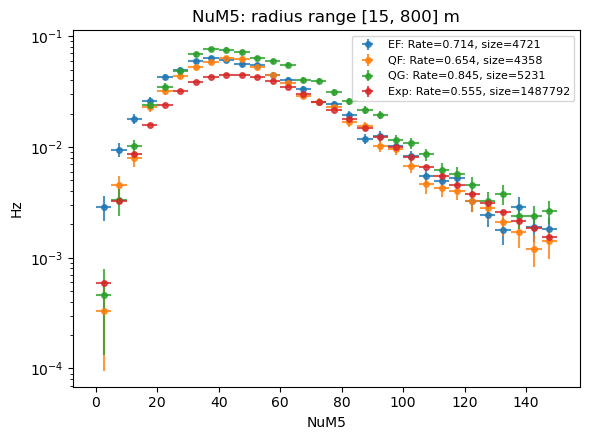

In [15]:
import matplotlib.pyplot as plt
import numpy as np
muon_params_dict={
    "NuM1":[15,200],   # name + label
    "NuM2":[40,100],
    "NuM3":[40,200],
    "NuM4":[15,400],
    "NuM5":[15,800],
}
df_dict={
    "EF":EF_df,
    "QF":QF_df,
    "QG":QG_df,
    "Exp":exp_df,
}


for NuM_name, r_range in muon_params_dict.items():
    
    # 建议创建一个新的 figure，防止之前遗留的设置干扰
    plt.figure(figsize=(6, 4.5))
    
    for df_name, df in df_dict.items():
        data = df[NuM_name]
        weights = df['weight']
        
        # 1. 使用 r_range 作为画图范围 (也可以手动指定 range=[0,200])
        # 这里我使用了字典里的 r_range，这样更灵活
        hist_range = [0,150]
        n_bins = 30
        
        # 2. 计算加权直方图的高度 (Y值)
        # y 是每个 bin 的加权和
        y, bin_edges = np.histogram(data, bins=n_bins, range=hist_range, weights=weights)
        
        # 3. 计算误差 (Y error)
        # 正确的加权误差公式: error = sqrt(sum(weights^2))
        y_var, _ = np.histogram(data, bins=n_bins, range=hist_range, weights=weights**2)
        y_err = np.sqrt(y_var)
        
        # 4. 计算 Bin 的中心点 (X值)
        # bin_edges 比 bin 的数量多 1，我们需要算出中心
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        x_err = (bin_edges[1] - bin_edges[0]) / 2
        # 5. 过滤掉计数为 0 的点（可选）
        # 在 log scale 下，y=0 会导致绘图问题或不美观，通常可以选择不画
        # mask = y > 0
        # plt.errorbar(bin_centers[mask], y[mask], yerr=y_err[mask], ...)
        
        # 6. 使用 errorbar 画图
        plt.errorbar(
            bin_centers, 
            y, 
            yerr=y_err, 
            xerr=x_err,
            label=f"{df_name}: Rate={weights.sum():.3f}, size={len(data)}",
            fmt='o',       # 'o' 表示只画点，如果想连线可以用 'o-'
            markersize=4,  # 点的大小
            capsize=0,     # 误差棒两端的小横杠宽度
            alpha=0.8,
        )

    plt.legend(fontsize=8)
    plt.xlabel(NuM_name)
    plt.ylabel("Hz")
    plt.yscale("log")
    # plt.xscale("log")
    plt.title(f"{NuM_name}: radius range {r_range} m")
    
    # 显式调用 layout 调整，防止标签被切掉
    plt.tight_layout()
    plt.show()
    plt.close()


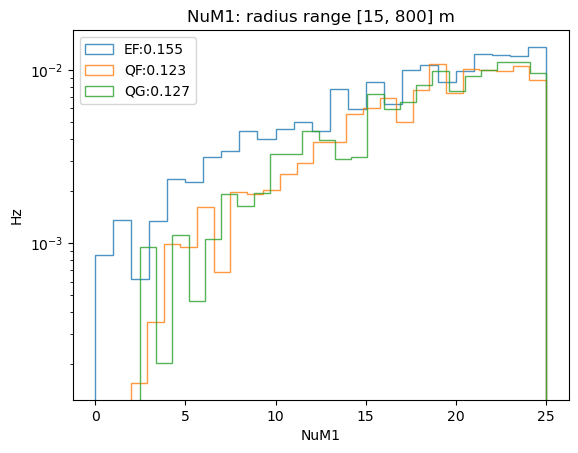

In [50]:
cut=25

EF_df_little_muon=EF_df[EF_df['NuM1']<cut]
QF_df_little_muon=QF_df[QF_df['NuM1']<cut]
QG_df_little_muon=QG_df[QG_df['NuM1']<cut]
plt.hist(EF_df_little_muon['NuM1'],bins=cut,weights=EF_df_little_muon['weight'],label=f"EF:{EF_df_little_muon['weight'].sum():.3f}", histtype="step", alpha=0.8)
plt.hist(QF_df_little_muon['NuM1'],bins=cut,weights=QF_df_little_muon['weight'],label=f"QF:{QF_df_little_muon['weight'].sum():.3f}", histtype="step", alpha=0.8)
plt.hist(QG_df_little_muon['NuM1'],bins=cut,weights=QG_df_little_muon['weight'],label=f"QG:{QG_df_little_muon['weight'].sum():.3f}", histtype="step", alpha=0.8)
plt.legend()
plt.xlabel("NuM1")
plt.ylabel("Hz")
plt.yscale("log")
plt.title(f"NuM1: radius range {r_range} m")
plt.show()
